In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
# Load data
data_white = pd.read_csv('data/winequality-white.csv', delimiter=';')
data_red = pd.read_csv('data/winequality-red.csv', delimiter=';')
data_white["type"] = 0
data_red["type"] = 1

In [3]:
data = data_white.append(data_red, ignore_index=True)
data = data.dropna()

In [4]:
X, y = data.drop('quality', axis=1), data.quality
y = (y<6).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

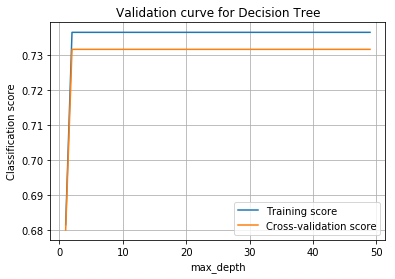

In [5]:
max_iter = 50
seed = 0
n_cv = 10 


nn = MLPClassifier(max_iter=2000,early_stopping=True,random_state=seed)

dt = DecisionTreeClassifier(random_state=seed, min_impurity_decrease=0.005)
depth_range = np.arange(1,max_depth)
train_scores, test_scores = validation_curve(dt, X_train, y_train, param_name="max_depth", param_range=depth_range, cv=n_cv, n_jobs=-1)

plt.figure()
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Decision Tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [6]:
depth_range = np.arange(1,max_depth)
tuned_params = {'max_depth' : depth_range}
clf_dt = GridSearchCV(dt, param_grid=tuned_params, cv=5, n_jobs=-1)

clf_dt.fit(X_train, y_train)
best_dt_params = clf_dt.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)
dt_pred_best = clf_dt.predict(X_test)
best_accuracy = accuracy_score(y_test, dt_pred_best)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy * 100))

Best parameters set for decision tree found on development set:
{'max_depth': 2}
Accuracy of decision tree is 73.54%


In [7]:
train_sizes=np.linspace(.3, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(clf_dt, X_train, y_train, cv=n_cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

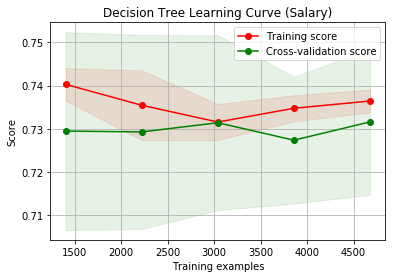

In [8]:
plt.figure()
plt.title("Decision Tree Learning Curve (Salary)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.show()

In [9]:
print(classification_report(y_test, clf_dt.predict(X_test)))

             precision    recall  f1-score   support

          0       0.83      0.84      0.83       832
          1       0.70      0.69      0.70       468

avg / total       0.78      0.78      0.78      1300

